In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/pack.zip'
extract_to = '/content/npz_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Files extracted to: {extract_to}')

Files extracted to: /content/npz_dataset


In [3]:
npz_directory = "/content/npz_dataset"  # Point to the extracted directory
visualization_output = "/content/visualizations"  # Save visualizations here

In [5]:
from torch.utils.data import Dataset
import os
import numpy as np
import torch

class StackedSliceDataset(Dataset):
    def __init__(self, npz_dir):
        self.dir = npz_dir
        self.files = sorted([f for f in os.listdir(npz_dir) if f.endswith('.npz')])
        self.paths = [os.path.join(npz_dir, f) for f in self.files]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        paths = self.paths
        idx_prev = max(0, idx - 1)
        idx_next = min(len(paths) - 1, idx + 1)

        def load_image(path):
            return np.load(path)['image']

        prev_img = load_image(paths[idx_prev])
        curr_img = load_image(paths[idx])
        next_img = load_image(paths[idx_next])

        # Stack as 3-channel input
        stacked_img = np.stack([prev_img, curr_img, next_img], axis=0)

        stacked_img = (stacked_img - stacked_img.mean()) / (stacked_img.std() + 1e-5)

        # Label is for the center slice
        label = np.load(paths[idx])['label']

        return torch.tensor(stacked_img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [6]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import random

class AugmentedStackedDataset(StackedSliceDataset):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)

        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.0)  # brightness factor
            image = TF.adjust_brightness(image, factor)

        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.0)  # contrast factor
            image = TF.adjust_contrast(image, factor)

        if torch.rand(1) > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        if torch.rand(1) > 0.5:
            angle = torch.randint(-5, 5, (1,)).item()
            image = TF.rotate(image, angle)
            label = TF.rotate(label.unsqueeze(0), angle, interpolation=TF.InterpolationMode.NEAREST).squeeze(0)

                # Affine (translation + scaling, no shear for now)
        if torch.rand(1) > 0.5:
            angle = 0  # no extra rotation
            translate = (random.randint(-5, 5), random.randint(-5, 5))
            scale = random.uniform(0.95, 1.05)
            image = TF.affine(image, angle=angle, translate=translate, scale=scale, shear=0)
            label = TF.affine(label.unsqueeze(0).float(), angle=angle, translate=translate, scale=scale,
                              shear=0, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        return image, label

<ipython-input-7-3466cdfcd4ce>:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(


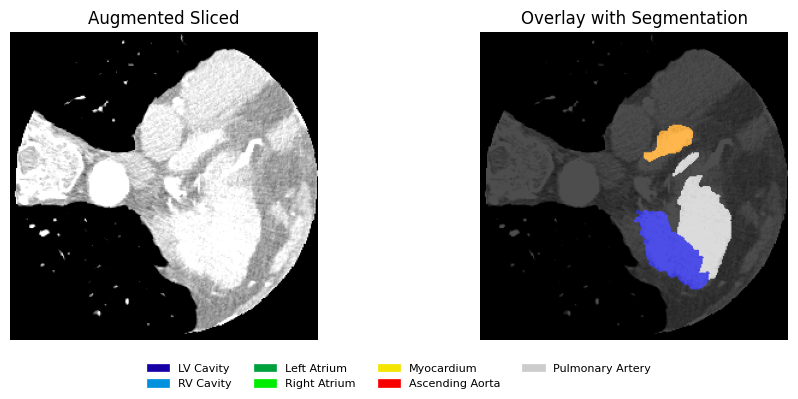

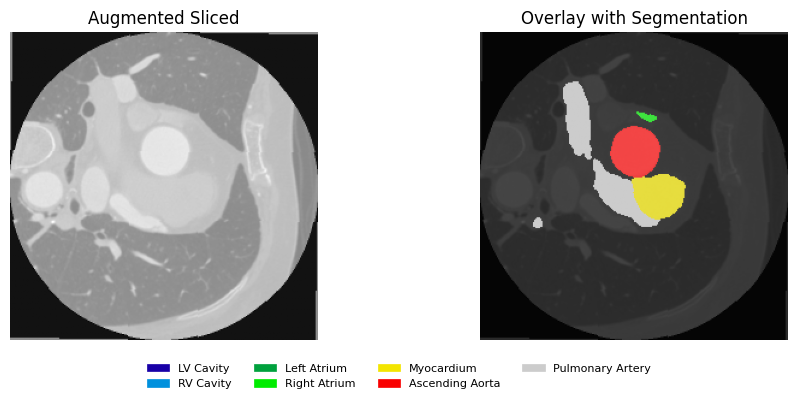

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import torch
import random
label_map = {
    1: "LV Cavity",
    2: "RV Cavity",
    3: "Left Atrium",
    4: "Right Atrium",
    5: "Myocardium",
    6: "Ascending Aorta",
    7: "Pulmonary Artery",
}

def denormalize_image(image):
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def visualize_augmented_samples(dataset, num_samples=2):
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        image_tensor, label_tensor = dataset[idx]

        image_np = image_tensor.numpy()
        label_np = label_tensor.numpy()

        center_slice = denormalize_image(image_np[1])

        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(center_slice, cmap='gray')
        axs[0].set_title("Augmented Sliced")
        axs[0].axis('off')

        axs[1].imshow(center_slice, cmap='gray')
        axs[1].imshow(label_np, cmap='nipy_spectral', alpha=0.7)
        axs[1].set_title("Overlay with Segmentation")
        axs[1].axis('off')

        cmap = plt.get_cmap("nipy_spectral")
        handles = [
            mpatches.Patch(
                color=cmap(cls / len(label_map)),
                label=label,
                edgecolor='black',
                linewidth=0.5
            )
            for cls, label in label_map.items()
        ]
        fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=8, handlelength=2)

        plt.tight_layout(rect=[0, 0.1, 1, 1])
        plt.show()

npz_dir = '/content/npz_dataset/pack/processed_data/ct_256/train/npz'
aug_dataset = AugmentedStackedDataset(npz_dir)
visualize_augmented_samples(aug_dataset, num_samples=2)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InitialBlock(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer=nn.BatchNorm2d):
        super(InitialBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias=False)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.bn = norm_layer(out_channels + in_channels)
        self.act = nn.PReLU()

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.maxpool(x)
        x = torch.cat([x_conv, x_pool], dim=1)
        x = self.bn(x)
        x = self.act(x)
        return x

class Bottleneck(nn.Module):
    def __init__(self, in_channels, inter_channels, out_channels, dilation=1, asymmetric=False,
                 downsampling=False, norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.downsampling = downsampling
        if downsampling:
            self.maxpool = nn.MaxPool2d(2, 2, return_indices=True)
            self.conv_down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                norm_layer(out_channels)
            )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 1, bias=False),
            norm_layer(inter_channels),
            nn.PReLU()
        )

        if downsampling:
            self.conv2 = nn.Sequential(
                nn.Conv2d(inter_channels, inter_channels, 2, stride=2, bias=False),
                norm_layer(inter_channels),
                nn.PReLU()
            )
        else:
            if asymmetric:
                self.conv2 = nn.Sequential(
                    nn.Conv2d(inter_channels, inter_channels, (5, 1), padding=(2, 0), bias=False),
                    nn.Conv2d(inter_channels, inter_channels, (1, 5), padding=(0, 2), bias=False),
                    norm_layer(inter_channels),
                    nn.PReLU()
                )
            else:
                self.conv2 = nn.Sequential(
                    nn.Conv2d(inter_channels, inter_channels, 3, dilation=dilation, padding=dilation, bias=False),
                    norm_layer(inter_channels),
                    nn.PReLU()
                )

        self.conv3 = nn.Sequential(
            nn.Conv2d(inter_channels, out_channels, 1, bias=False),
            norm_layer(out_channels),
            nn.Dropout2d(0.1)
        )
        self.act = nn.PReLU()

    def forward(self, x):
        identity = x
        if self.downsampling:
            identity, max_indices = self.maxpool(identity)
            identity = self.conv_down(identity)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.act(out + identity)

        if self.downsampling:
            return out, max_indices
        else:
            return out

class UpsamplingBottleneck(nn.Module):
    def __init__(self, in_channels, inter_channels, out_channels, norm_layer=nn.BatchNorm2d):
        super(UpsamplingBottleneck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            norm_layer(out_channels)
        )
        self.upsample = nn.MaxUnpool2d(2)

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 1, bias=False),
            norm_layer(inter_channels),
            nn.PReLU(),
            nn.ConvTranspose2d(inter_channels, inter_channels, 2, 2, bias=False),
            norm_layer(inter_channels),
            nn.PReLU(),
            nn.Conv2d(inter_channels, out_channels, 1, bias=False),
            norm_layer(out_channels),
            nn.Dropout2d(0.1)
        )
        self.act = nn.PReLU()

    def forward(self, x, max_indices):
        out_up = self.conv(x)
        out_up = self.upsample(out_up, max_indices)
        out_ext = self.block(x)
        return self.act(out_up + out_ext)

class ENet(nn.Module):
    def __init__(self, nclass, in_channels=9):
        super(ENet, self).__init__()
        self.initial = InitialBlock(in_channels, 13)

        self.bottleneck1_0 = Bottleneck(16, 16, 64, downsampling=True)
        self.bottleneck1_1 = Bottleneck(64, 16, 64)
        self.bottleneck1_2 = Bottleneck(64, 16, 64)
        self.bottleneck1_3 = Bottleneck(64, 16, 64)
        self.bottleneck1_4 = Bottleneck(64, 16, 64)

        self.bottleneck2_0 = Bottleneck(64, 32, 128, downsampling=True)
        self.bottleneck2_1 = Bottleneck(128, 32, 128)
        self.bottleneck2_2 = Bottleneck(128, 32, 128, dilation=2)
        self.bottleneck2_3 = Bottleneck(128, 32, 128, asymmetric=True)
        self.bottleneck2_4 = Bottleneck(128, 32, 128, dilation=4)
        self.bottleneck2_5 = Bottleneck(128, 32, 128)
        self.bottleneck2_6 = Bottleneck(128, 32, 128, dilation=8)
        self.bottleneck2_7 = Bottleneck(128, 32, 128, asymmetric=True)
        self.bottleneck2_8 = Bottleneck(128, 32, 128, dilation=16)

        self.bottleneck3_1 = Bottleneck(128, 32, 128)
        self.bottleneck3_2 = Bottleneck(128, 32, 128, dilation=2)
        self.bottleneck3_3 = Bottleneck(128, 32, 128, asymmetric=True)
        self.bottleneck3_4 = Bottleneck(128, 32, 128, dilation=4)
        self.bottleneck3_5 = Bottleneck(128, 32, 128)
        self.bottleneck3_6 = Bottleneck(128, 32, 128, dilation=8)
        self.bottleneck3_7 = Bottleneck(128, 32, 128, asymmetric=True)
        self.bottleneck3_8 = Bottleneck(128, 32, 128, dilation=16)

        self.bottleneck4_0 = UpsamplingBottleneck(128, 16, 64)
        self.bottleneck4_1 = Bottleneck(64, 16, 64)
        self.bottleneck4_2 = Bottleneck(64, 16, 64)

        self.bottleneck5_0 = UpsamplingBottleneck(64, 4, 16)
        self.bottleneck5_1 = Bottleneck(16, 4, 16)

        self.fullconv = nn.ConvTranspose2d(16, nclass, 2, 2, bias=False)

    def forward(self, x):
        low_feature = self.initial(x)

        x, max_indices1 = self.bottleneck1_0(low_feature)
        x = self.bottleneck1_1(x)
        x = self.bottleneck1_2(x)
        x = self.bottleneck1_3(x)
        x = self.bottleneck1_4(x)

        x, max_indices2 = self.bottleneck2_0(x)
        x = self.bottleneck2_1(x)
        x = self.bottleneck2_2(x)
        x = self.bottleneck2_3(x)
        x = self.bottleneck2_4(x)
        x = self.bottleneck2_5(x)
        x = self.bottleneck2_6(x)
        x = self.bottleneck2_7(x)
        x = self.bottleneck2_8(x)

        x = self.bottleneck3_1(x)
        x = self.bottleneck3_2(x)
        x = self.bottleneck3_3(x)
        x = self.bottleneck3_4(x)
        x = self.bottleneck3_5(x)
        x = self.bottleneck3_6(x)
        x = self.bottleneck3_7(x)
        x = self.bottleneck3_8(x)
        high_feature = x

        x = self.bottleneck4_0(x, max_indices2)
        x = self.bottleneck4_1(x)
        x = self.bottleneck4_2(x)

        x = self.bottleneck5_0(x, max_indices1)
        x = self.bottleneck5_1(x)

        x = self.fullconv(x)
        return F.log_softmax(x, dim=1), low_feature, high_feature

In [13]:
class FocalNLLLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        probs = torch.exp(inputs)
        targets = targets.unsqueeze(1)
        probs = torch.gather(probs, 1, targets).squeeze(1)
        focal_factor = (1 - probs) ** self.gamma
        loss = F.nll_loss(inputs, targets.squeeze(1), weight=self.weight, reduction='none')
        return (focal_factor * loss).mean()

class CELDiceFocal(nn.Module):
    def __init__(self, dice_weight=0.5, num_classes=8, gamma=2.0):
        super(CELDiceFocal, self).__init__()
        class_weights = torch.tensor([0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda()
        self.ce = FocalNLLLoss(gamma=gamma, weight=class_weights)
        self.dice_weight = dice_weight
        self.num_classes = num_classes

    def forward(self, outputs, targets):
        ce_loss = self.ce(outputs, targets)
        dice_loss = self.multi_class_dice_loss(outputs, targets)
        total_loss = (1 - self.dice_weight) * ce_loss + self.dice_weight * dice_loss
        return total_loss

    def multi_class_dice_loss(self, outputs, targets, eps=1e-6):
        probs = torch.exp(outputs)
        targets_one_hot = torch.nn.functional.one_hot(targets, self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        dims = (0, 2, 3)
        intersection = torch.sum(probs * targets_one_hot, dims)
        cardinality = torch.sum(probs + targets_one_hot, dims)
        dice = (2. * intersection + eps) / (cardinality + eps)
        return 1 - dice.mean()

In [14]:
import numpy as np
import torch
import tqdm
import math
from torch import nn

def val_multi(model: nn.Module, criterion, valid_loader, num_classes, batch_size, device_ids, ignore_index=0):
    with torch.no_grad():
        model.eval()
        losses = []
        confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
        dt_size = len(valid_loader.dataset)
        tq = tqdm.tqdm(total=math.ceil(dt_size / batch_size))
        tq.set_description('Validation')

        for inputs, targets in valid_loader:
            inputs = inputs.cuda(device_ids[0])
            targets = targets.long().cuda(device_ids[0])
            logits, _, _ = model(inputs)

            loss = criterion(logits, targets)
            losses.append(loss.item())

            preds = logits.data.cpu().numpy().argmax(axis=1)
            targets_np = targets.data.cpu().numpy()

            confusion_matrix += calculate_confusion_matrix_from_arrays(
                preds, targets_np, num_classes
            )
            tq.update(1)
        tq.close()

        if ignore_index is not None:
            confusion_matrix[ignore_index, :] = 0
            confusion_matrix[:, ignore_index] = 0

        valid_loss = np.mean(losses)
        ious = calculate_iou(confusion_matrix)
        dices = calculate_dice(confusion_matrix)

        avg_iou = np.mean(ious)
        avg_dice = np.mean(dices)

        print(f"\nValidation Loss: {valid_loss:.4f}")
        print(f"Average IoU: {avg_iou:.4f}")
        print(f"Average Dice: {avg_dice:.4f}")

        return avg_dice, avg_iou, dices


def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((ground_truth.flatten(), prediction.flatten())).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    return confusion_matrix.astype(np.uint32)


def calculate_iou(confusion_matrix):
    ious = []
    for index in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[index, index]
        fp = confusion_matrix[:, index].sum() - tp
        fn = confusion_matrix[index, :].sum() - tp
        denom = tp + fp + fn
        iou = float(tp) / denom if denom else 0
        ious.append(iou)
    return ious


def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[index, index]
        fp = confusion_matrix[:, index].sum() - tp
        fn = confusion_matrix[index, :].sum() - tp
        denom = 2 * tp + fp + fn
        dice = 2 * float(tp) / denom if denom else 0
        dices.append(dice)
    return dices

[Epoch 1/20] Loss: 0.9288


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.73it/s]


Validation Loss: 0.9220
Average IoU: 0.0660
Average Dice: 0.1203


[Epoch 2/20] Loss: 0.8477


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.27it/s]


Validation Loss: 0.8008
Average IoU: 0.0706
Average Dice: 0.1236


[Epoch 3/20] Loss: 0.7507


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.33it/s]


Validation Loss: 0.7187
Average IoU: 0.0827
Average Dice: 0.1353


[Epoch 4/20] Loss: 0.6853


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.34it/s]


Validation Loss: 0.6673
Average IoU: 0.1015
Average Dice: 0.1592


[Epoch 5/20] Loss: 0.6435


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.38it/s]


Validation Loss: 0.6414
Average IoU: 0.1606
Average Dice: 0.2245


[Epoch 6/20] Loss: 0.6132


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.63it/s]


Validation Loss: 0.6263
Average IoU: 0.1813
Average Dice: 0.2415


[Epoch 7/20] Loss: 0.5816


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.59it/s]


Validation Loss: 0.6073
Average IoU: 0.1620
Average Dice: 0.2028


[Epoch 8/20] Loss: 0.5528


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.53it/s]


Validation Loss: 0.5940
Average IoU: 0.1634
Average Dice: 0.2019


[Epoch 9/20] Loss: 0.5301


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.65it/s]


Validation Loss: 0.5811
Average IoU: 0.1653
Average Dice: 0.2039


[Epoch 10/20] Loss: 0.5072


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.63it/s]


Validation Loss: 0.5625
Average IoU: 0.2163
Average Dice: 0.2845


[Epoch 11/20] Loss: 0.4761


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.59it/s]


Validation Loss: 0.5622
Average IoU: 0.3339
Average Dice: 0.4348


[Epoch 12/20] Loss: 0.4208


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.56it/s]


Validation Loss: 0.5193
Average IoU: 0.4211
Average Dice: 0.5135


[Epoch 13/20] Loss: 0.3629


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.59it/s]


Validation Loss: 0.4895
Average IoU: 0.4473
Average Dice: 0.5272


[Epoch 14/20] Loss: 0.3165


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.49it/s]


Validation Loss: 0.4778
Average IoU: 0.4609
Average Dice: 0.5575


[Epoch 15/20] Loss: 0.2795


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.57it/s]


Validation Loss: 0.4810
Average IoU: 0.5842
Average Dice: 0.6889


[Epoch 16/20] Loss: 0.2348


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.61it/s]


Validation Loss: 0.4397
Average IoU: 0.6800
Average Dice: 0.7608


[Epoch 17/20] Loss: 0.1954


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.60it/s]


Validation Loss: 0.4393
Average IoU: 0.6983
Average Dice: 0.7736


[Epoch 18/20] Loss: 0.1674


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.67it/s]


Validation Loss: 0.4279
Average IoU: 0.7092
Average Dice: 0.7800


[Epoch 19/20] Loss: 0.1462


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.64it/s]


Validation Loss: 0.4183
Average IoU: 0.7188
Average Dice: 0.7853


[Epoch 20/20] Loss: 0.1318


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.59it/s]



Validation Loss: 0.4228
Average IoU: 0.7231
Average Dice: 0.7875


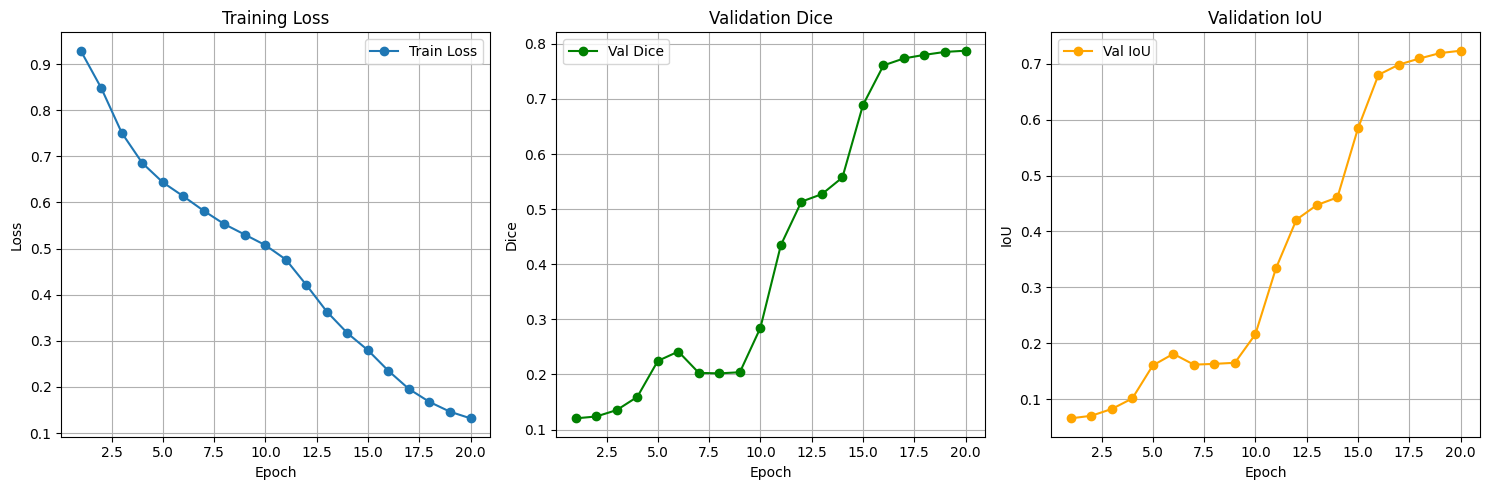


Final Per-Class Dice Evaluation


Validation: 100%|██████████| 24/24 [00:03<00:00,  7.54it/s]


Validation Loss: 0.4228
Average IoU: 0.7231
Average Dice: 0.7875

Per-Class Dice Scores:
  Background          : Dice = 0.0000
  LV                  : Dice = 0.7339
  RV                  : Dice = 0.9456
  LA                  : Dice = 0.8661
  RA                  : Dice = 0.9689
  Myocardium          : Dice = 0.9001
  Aorta               : Dice = 0.9739
  Pulmonary Artery    : Dice = 0.9116


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_dir = '/content/npz_dataset/pack/processed_data/ct_256/train/npz'
val_dir = '/content/npz_dataset/pack/processed_data/ct_256/val/npz'


num_classes = 8
batch_size = 16
lr = 1e-4
num_epochs = 20

train_dataset = AugmentedStackedDataset(train_dir)
val_dataset = StackedSliceDataset(val_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = ENet(nclass=8, in_channels=3).cuda()

criterion = CELDiceFocal(dice_weight=0.7, num_classes=num_classes)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

train_losses, val_dices, val_ious = [], [], []

# Training
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []

    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()

        optimizer.zero_grad()
        logits, _, _ = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    dice, iou, _ = val_multi(model, criterion, val_loader, num_classes, batch_size, [0], ignore_index=0)
    val_dices.append(dice)
    val_ious.append(iou)
    scheduler.step(dice)

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"ct_teacher_epoch{epoch+1}.pth")

# Plotting
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_dices, marker='o', color='green', label='Val Dice')
plt.title("Validation Dice")
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.grid(True); plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_ious, marker='o', color='orange', label='Val IoU')
plt.title("Validation IoU")
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# Final Evaluation with Per-Class Dice
print("\nFinal Per-Class Dice Evaluation")
_, _, per_class_dices = val_multi(model, criterion, val_loader, num_classes, batch_size, [0], ignore_index=0)

label_names = [
    "Background", "LV", "RV", "LA", "RA", "Myocardium", "Aorta", "Pulmonary Artery"
]

print("\nPer-Class Dice Scores:")
for i, score in enumerate(per_class_dices):
    print(f"  {label_names[i]:<20}: Dice = {score:.4f}")

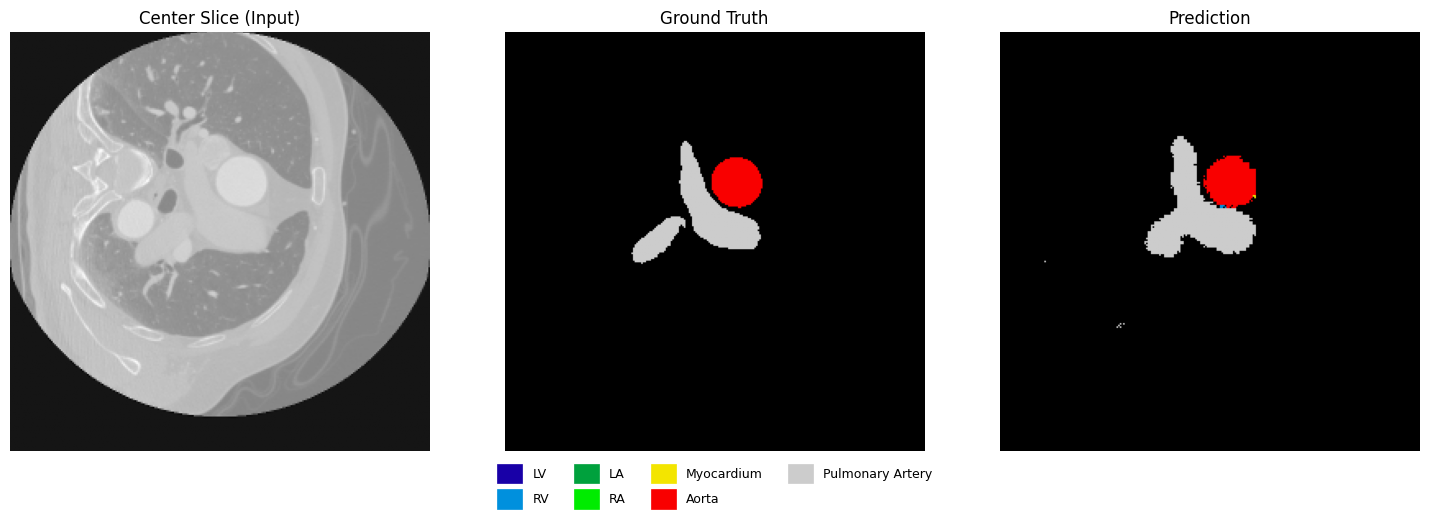

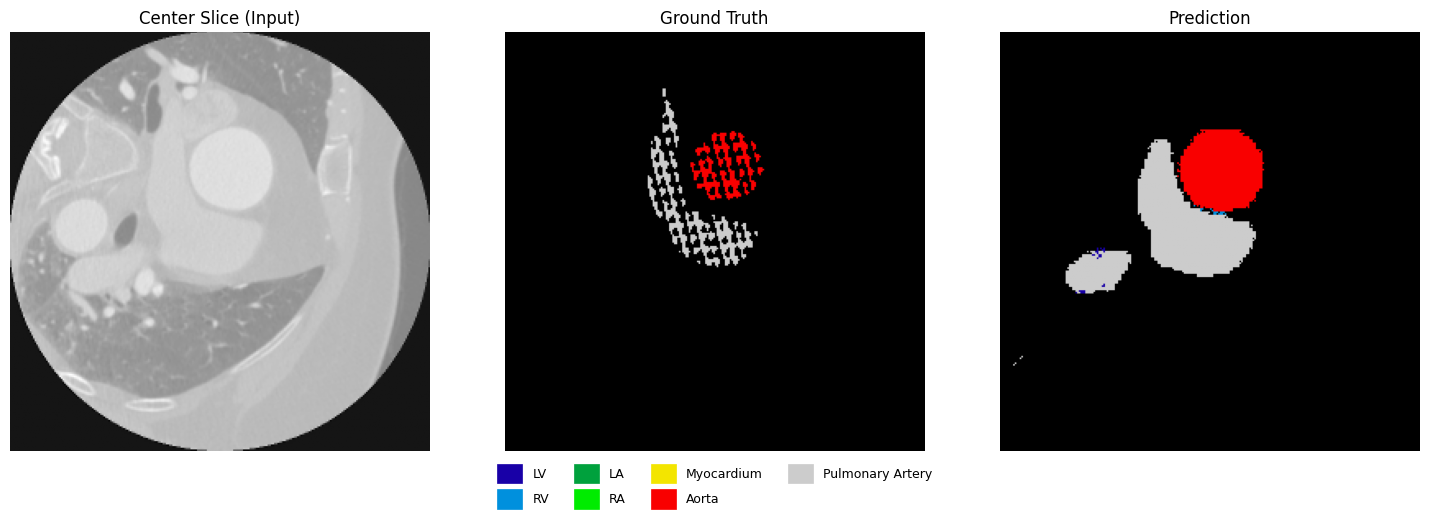

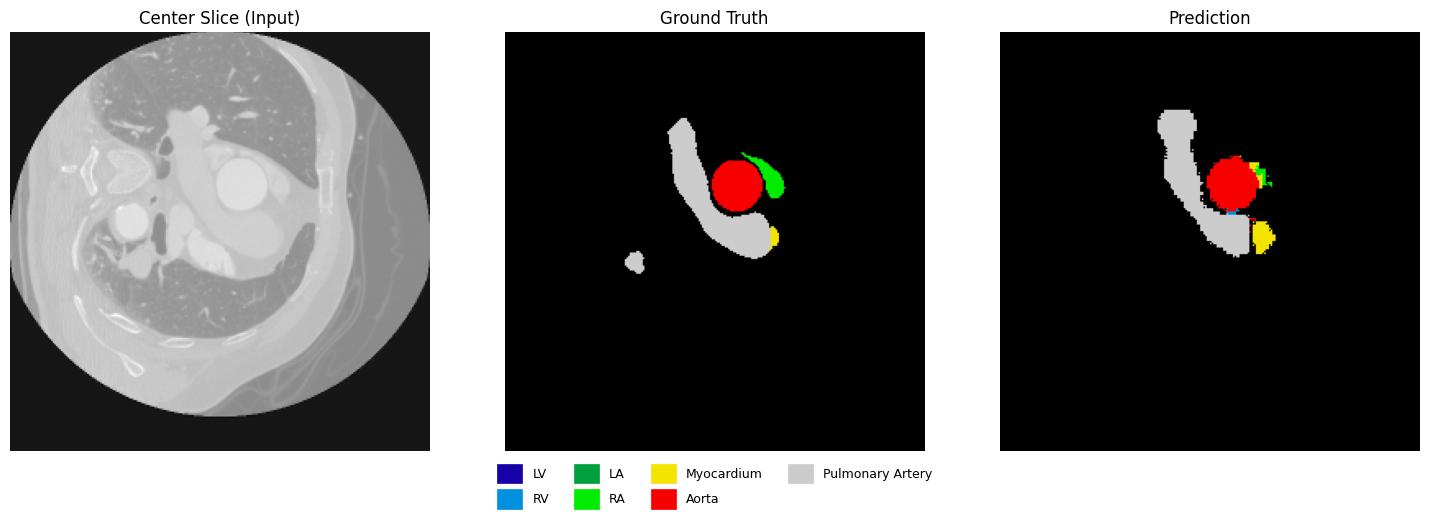

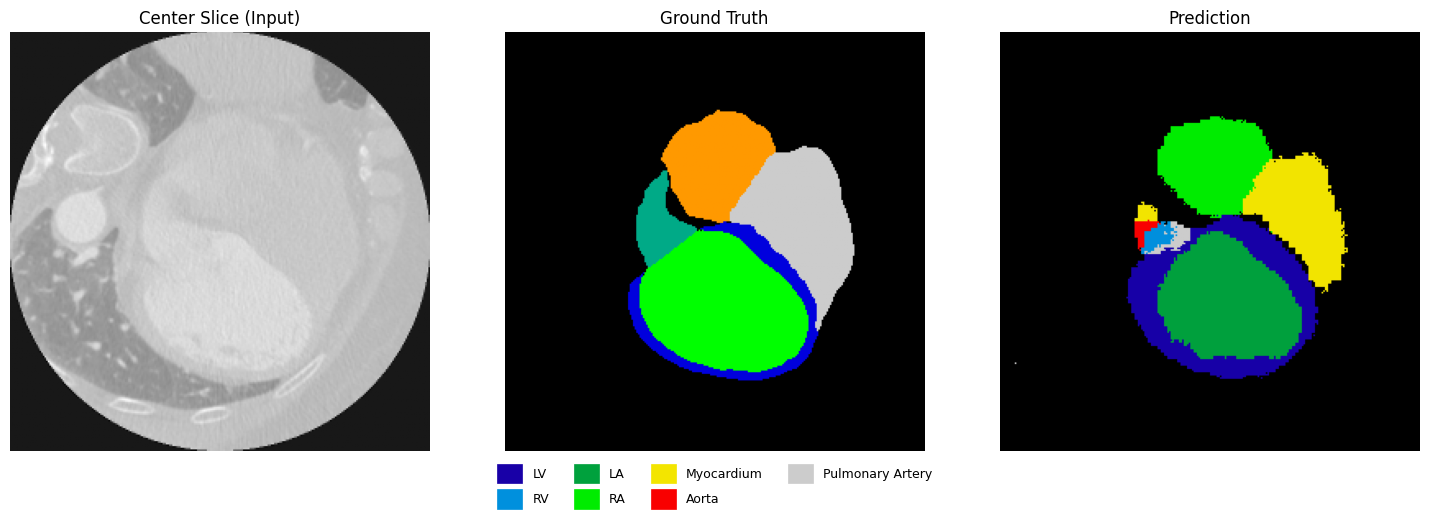

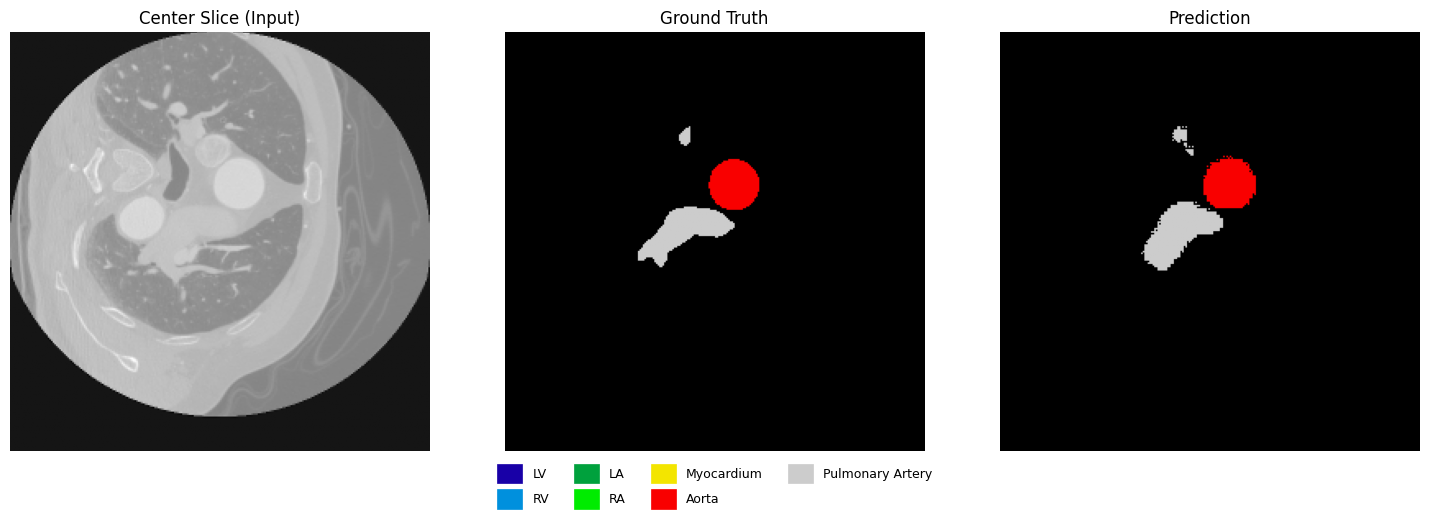

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn.functional as F
import random

model.eval()

label_map = {
    1: "LV",
    2: "RV",
    3: "LA",
    4: "RA",
    5: "Myocardium",
    6: "Aorta",
    7: "Pulmonary Artery"
}

val_samples = list(val_dataset)
num_to_show = 5

random_indices = random.sample(range(len(val_samples)), num_to_show)

for idx in random_indices:
    image, mask = val_dataset[idx]
    input_tensor = image.unsqueeze(0).cuda()

    with torch.no_grad():
        logits, _, _ = model(input_tensor)
        pred = torch.argmax(F.softmax(logits, dim=1), dim=1).squeeze().cpu().numpy()

    input_center = image[1].cpu().numpy()
    gt = mask.numpy()

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(input_center, cmap='gray')
    axs[0].set_title("Center Slice (Input)")
    axs[0].axis('off')

    axs[1].imshow(gt, cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred, cmap='nipy_spectral')
    axs[2].set_title("Prediction")
    axs[2].axis('off')

    cmap = plt.get_cmap("nipy_spectral")
    handles = [
        mpatches.Patch(
            color=cmap(cls / len(label_map)),
            label=name,
            linewidth=0.5
        )
        for cls, name in label_map.items()
    ]
    fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=9, handleheight=2, handlelength=2)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

Test Inference: 100%|██████████| 31/31 [00:08<00:00,  3.72it/s]



Per-Class Dice Scores (Test Set):
  LV                  : Dice = 0.8086
  RV                  : Dice = 0.5437
  LA                  : Dice = 0.7048
  RA                  : Dice = 0.7344
  Myocardium          : Dice = 0.6587
  Aorta               : Dice = 0.7612
  Pulmonary Artery    : Dice = 0.3021

Average Dice Score on Test Set: 0.6052


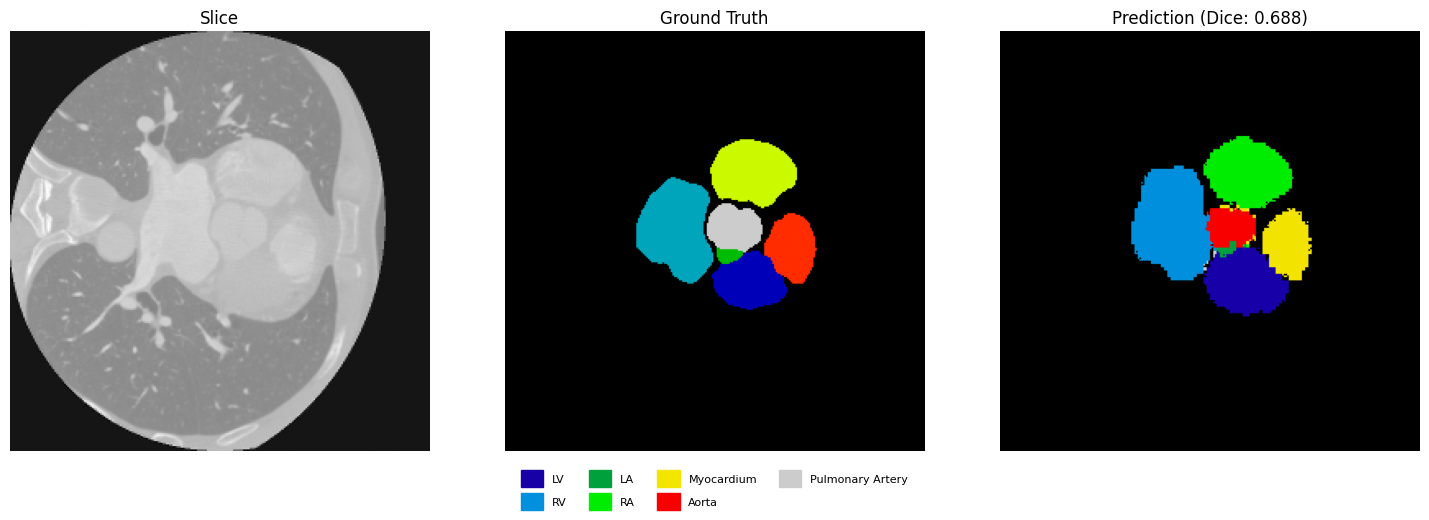

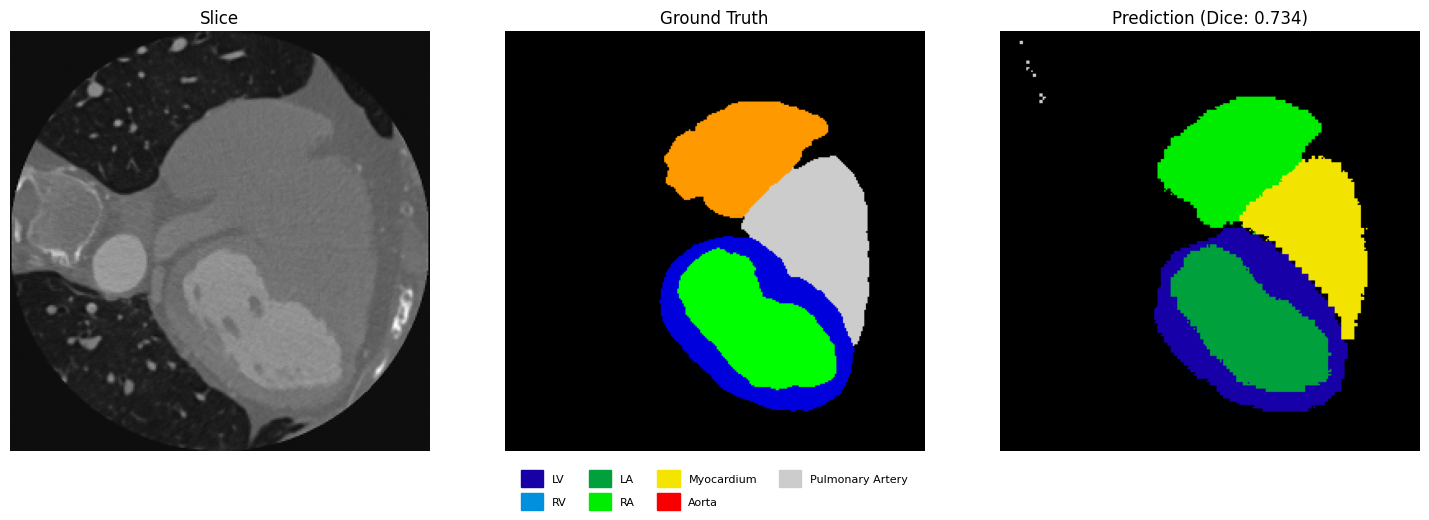

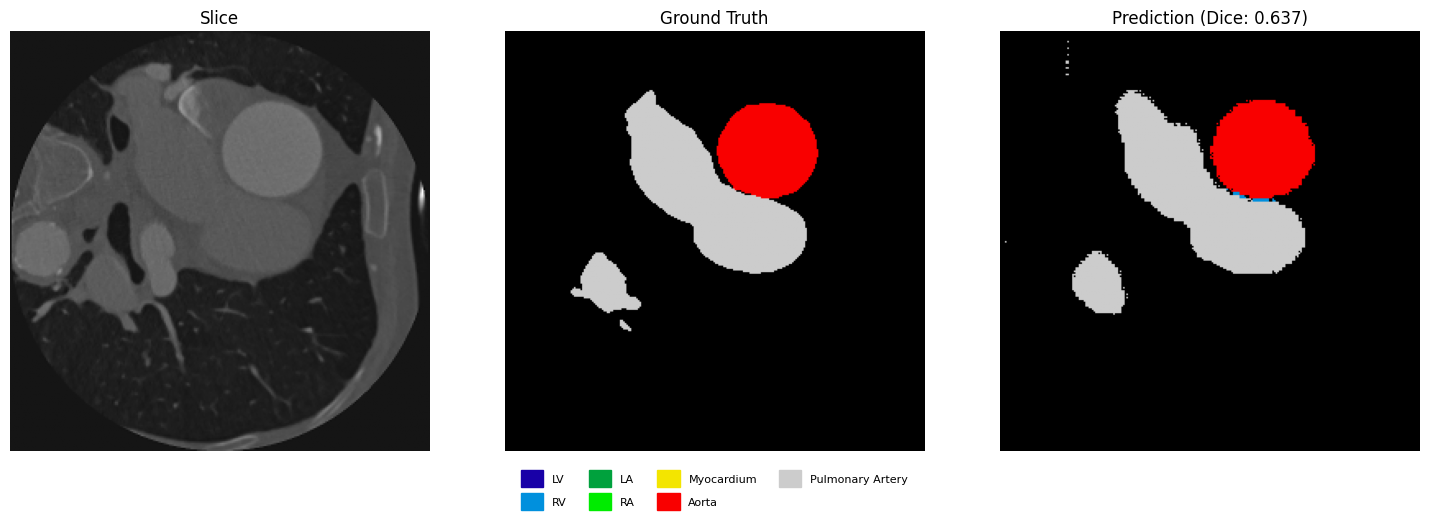

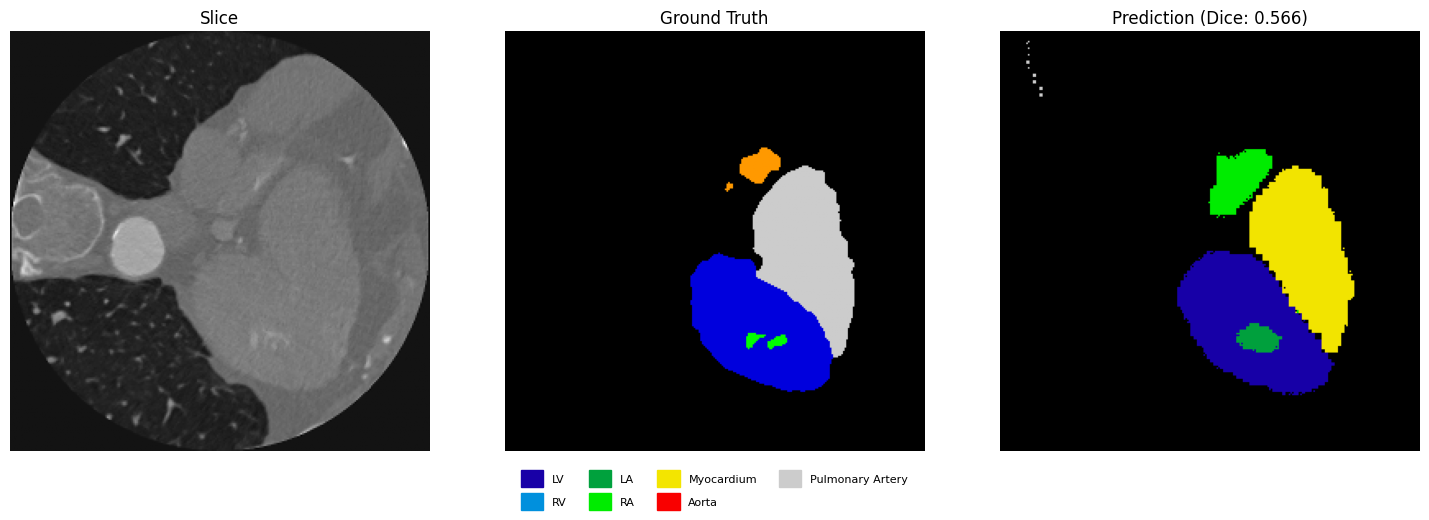

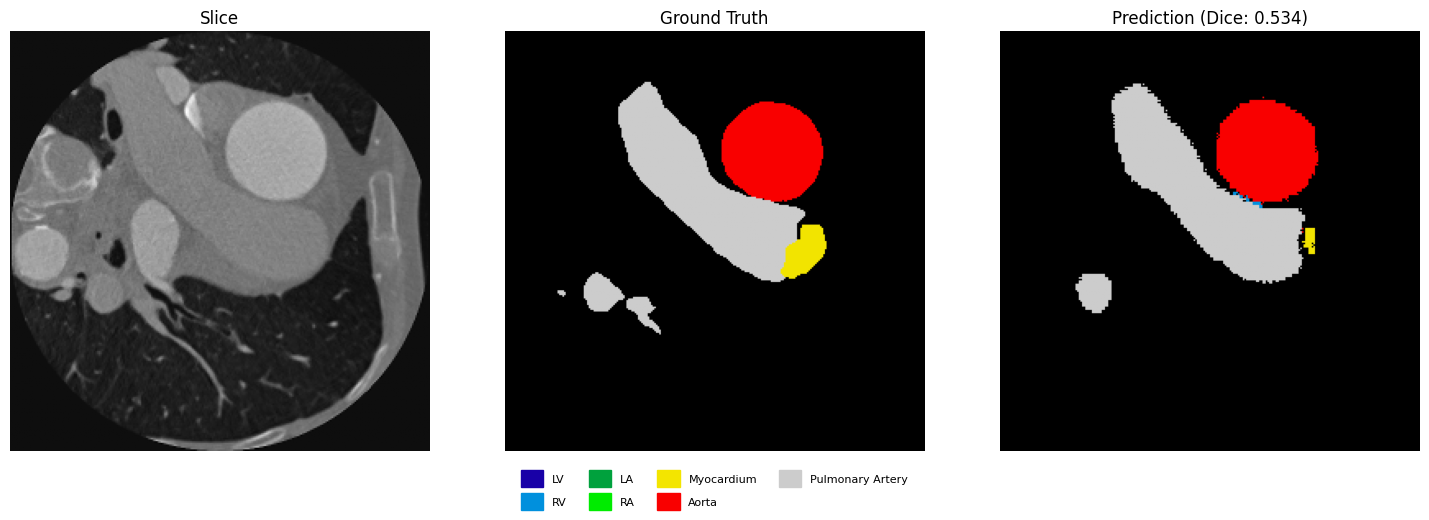

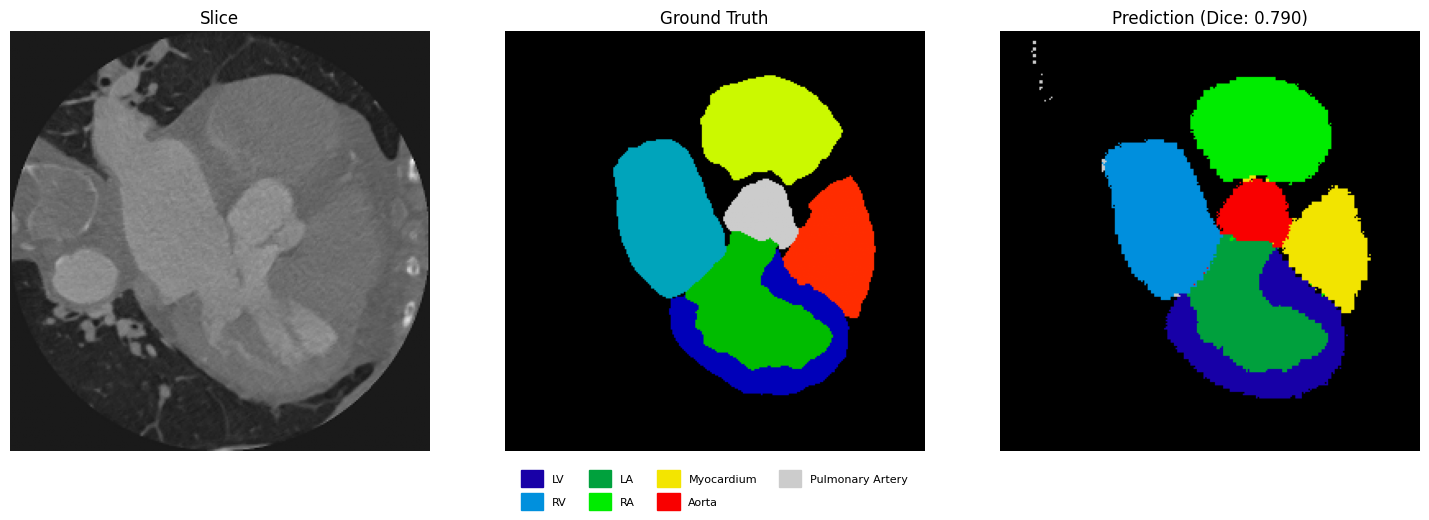

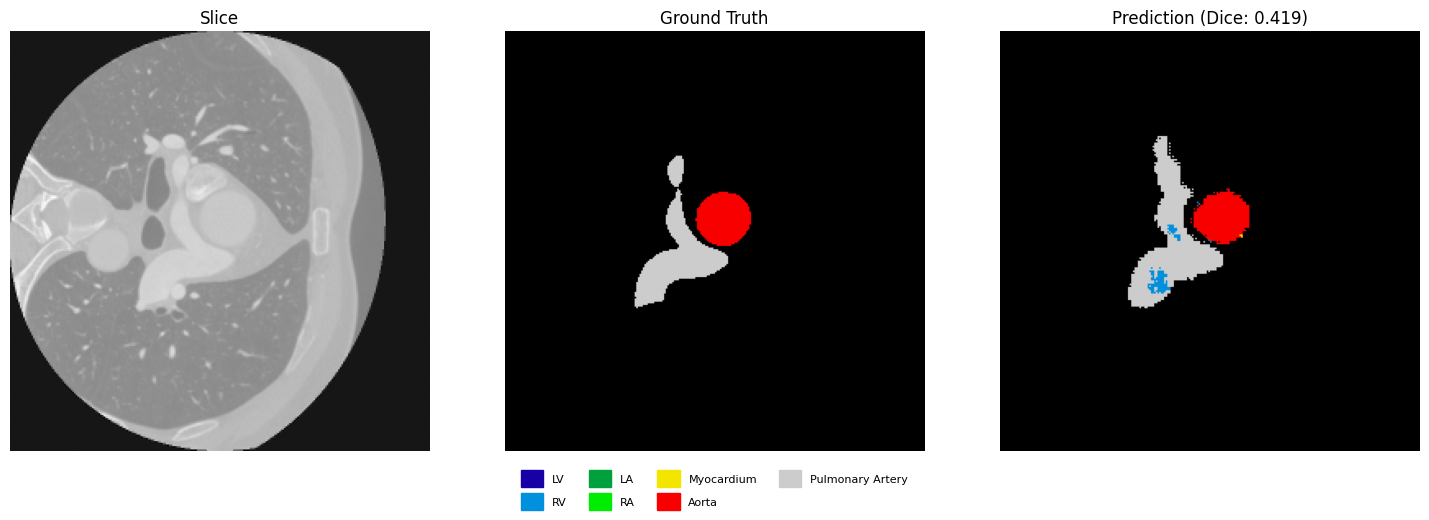

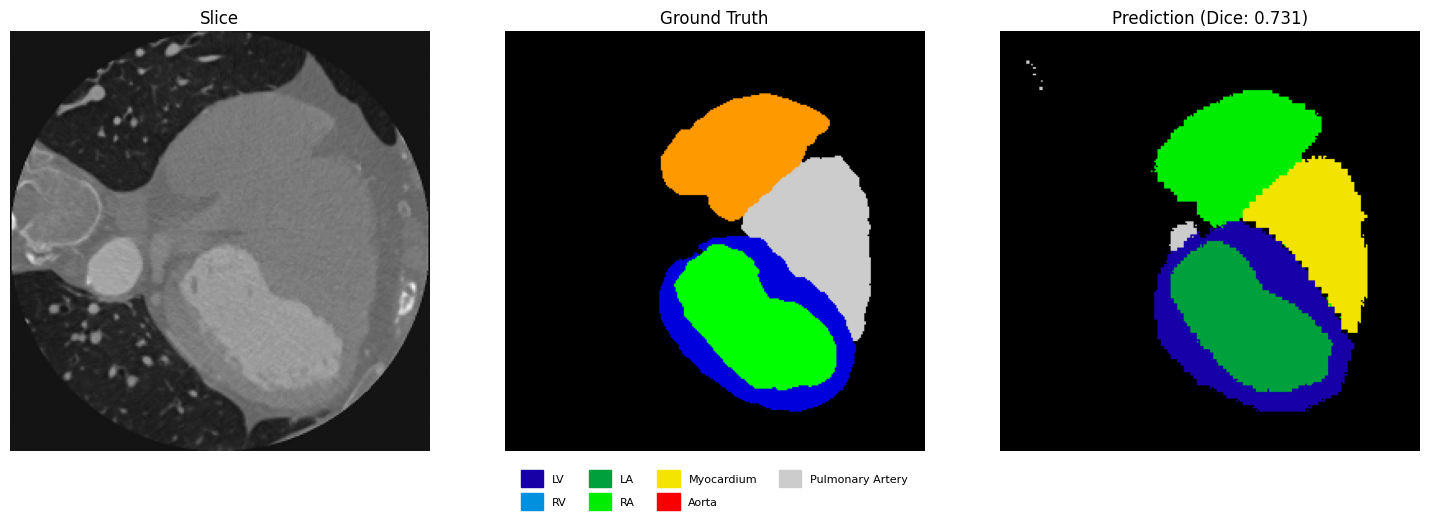

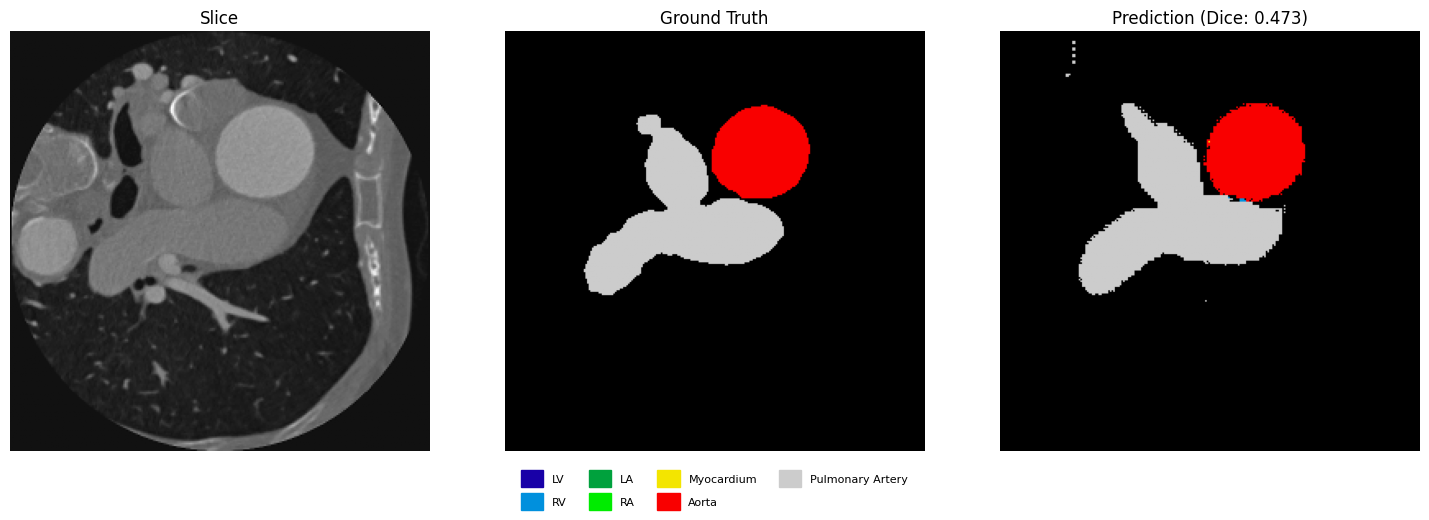

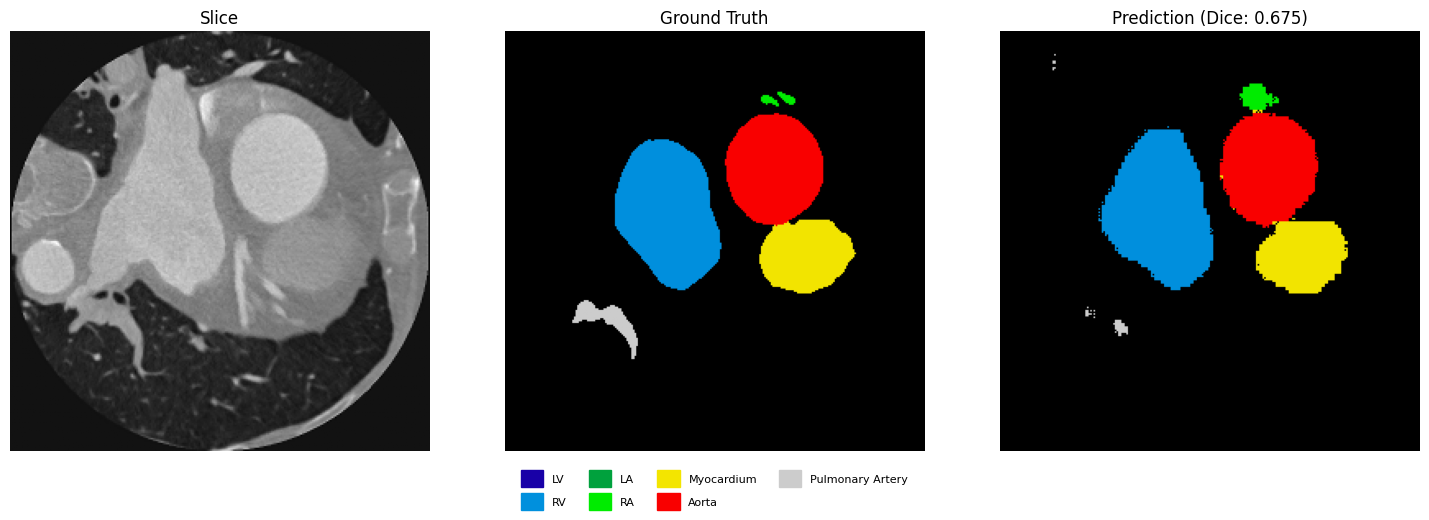

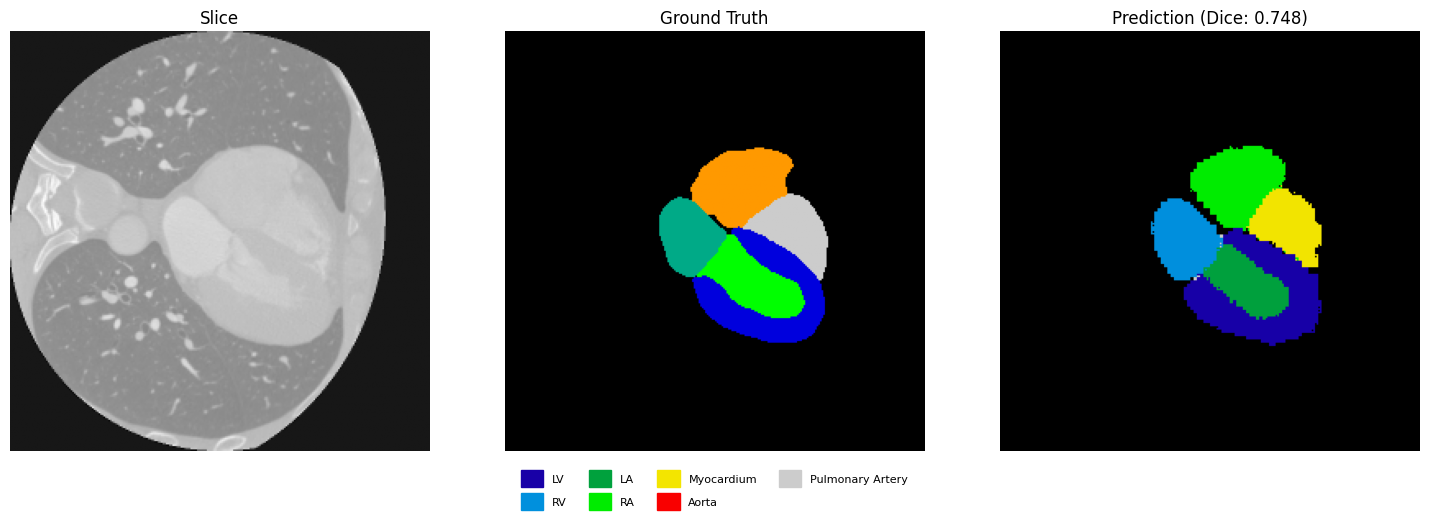

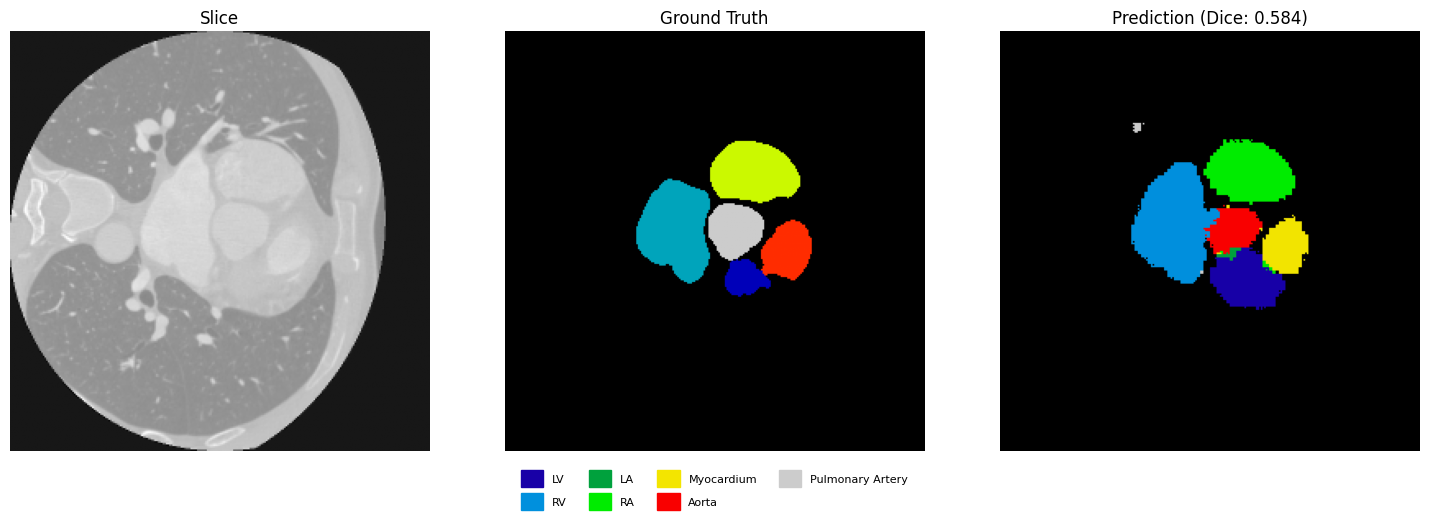

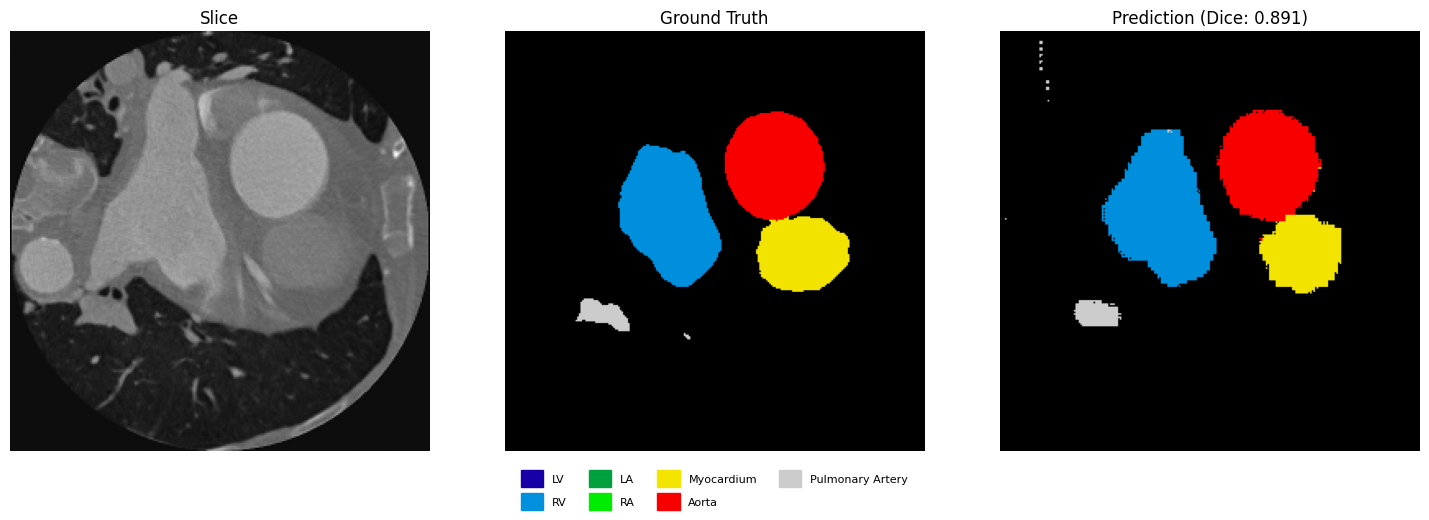

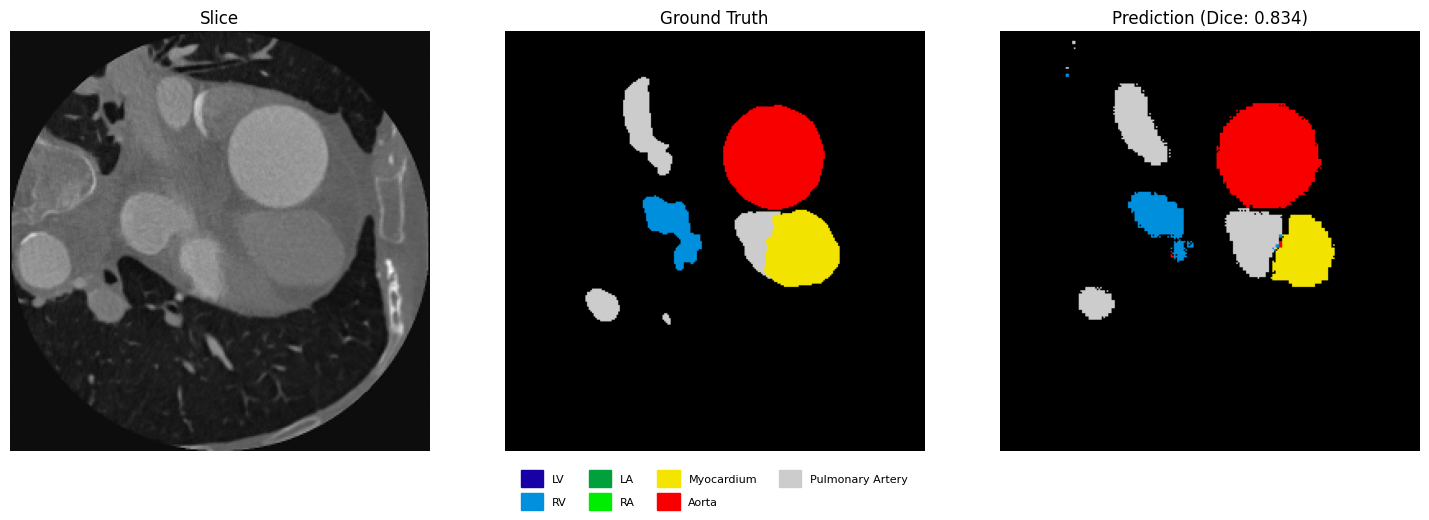

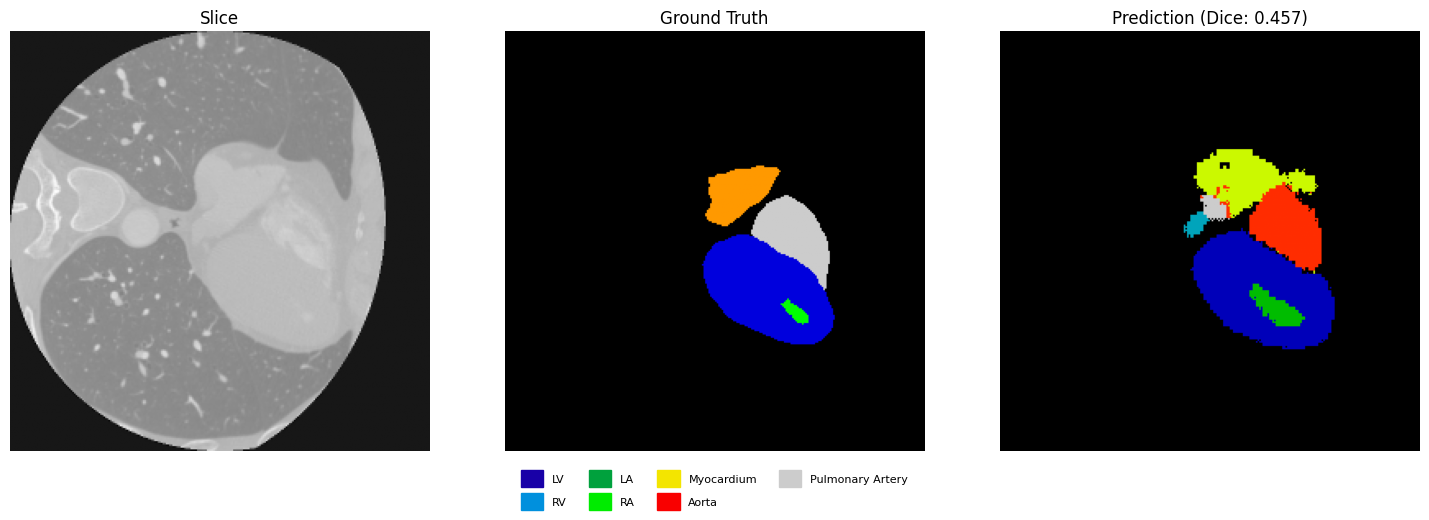

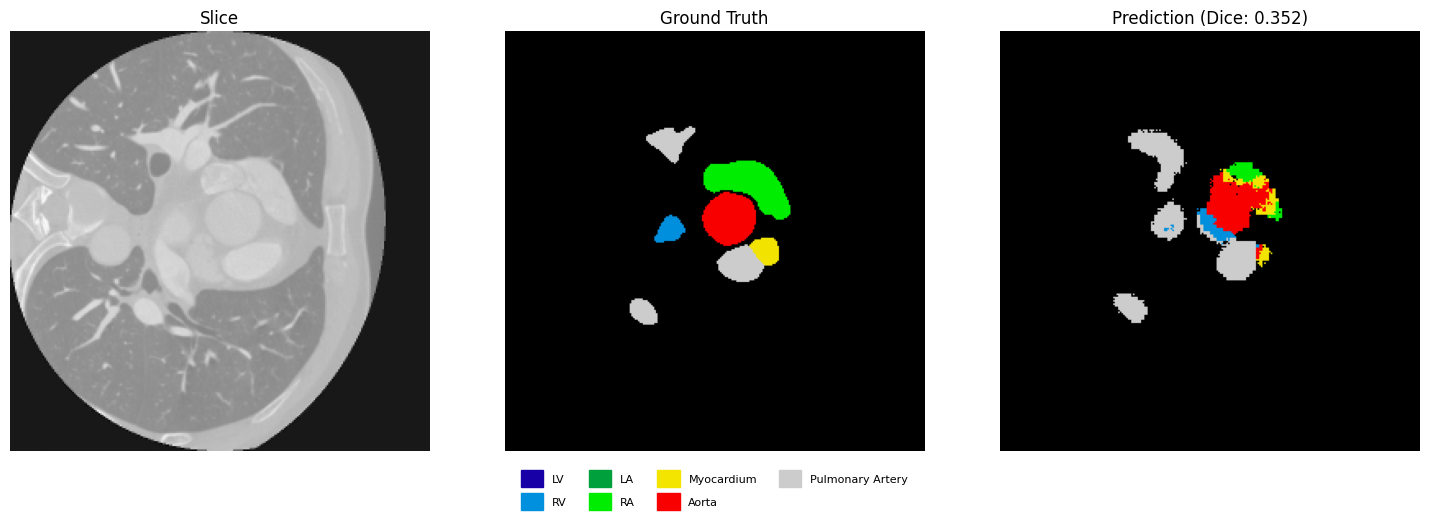

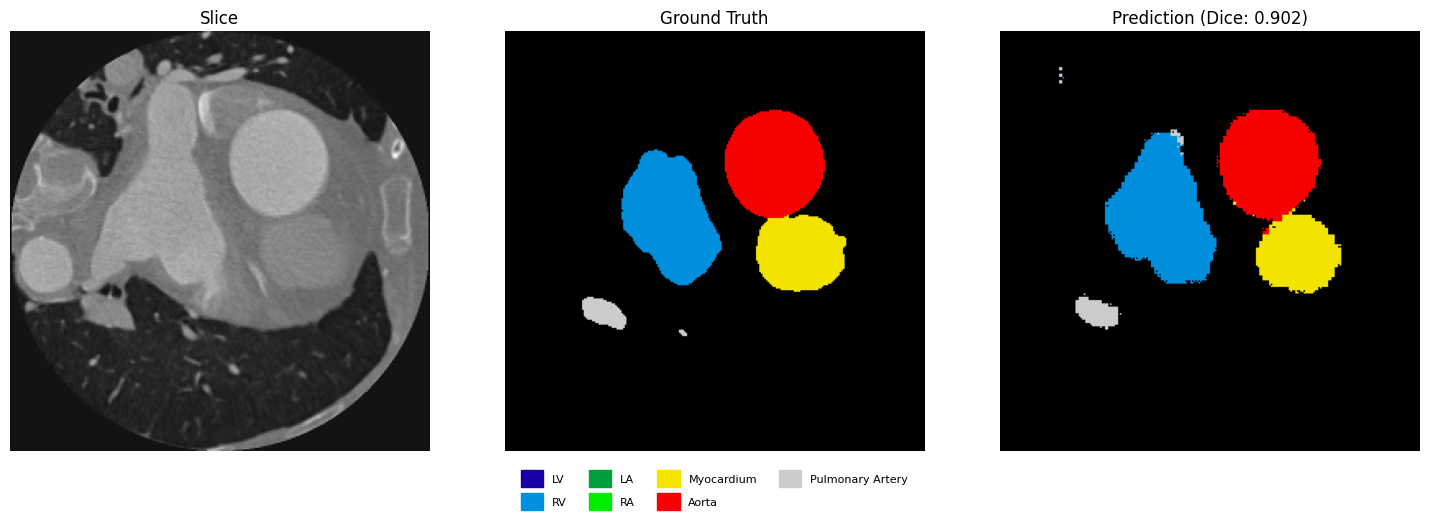

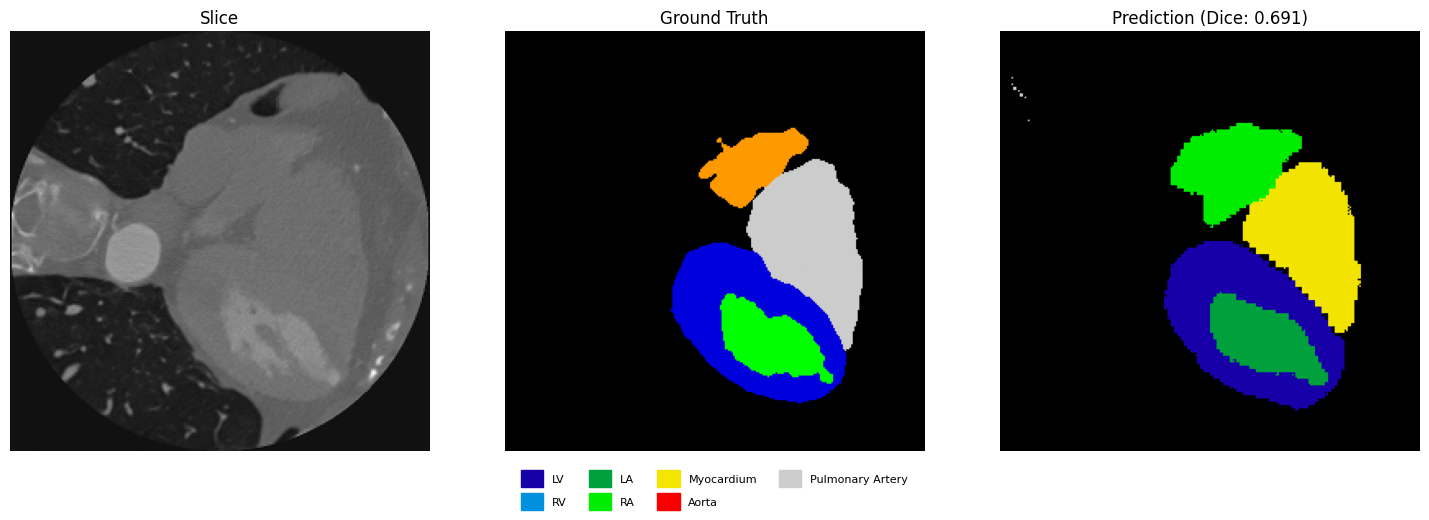

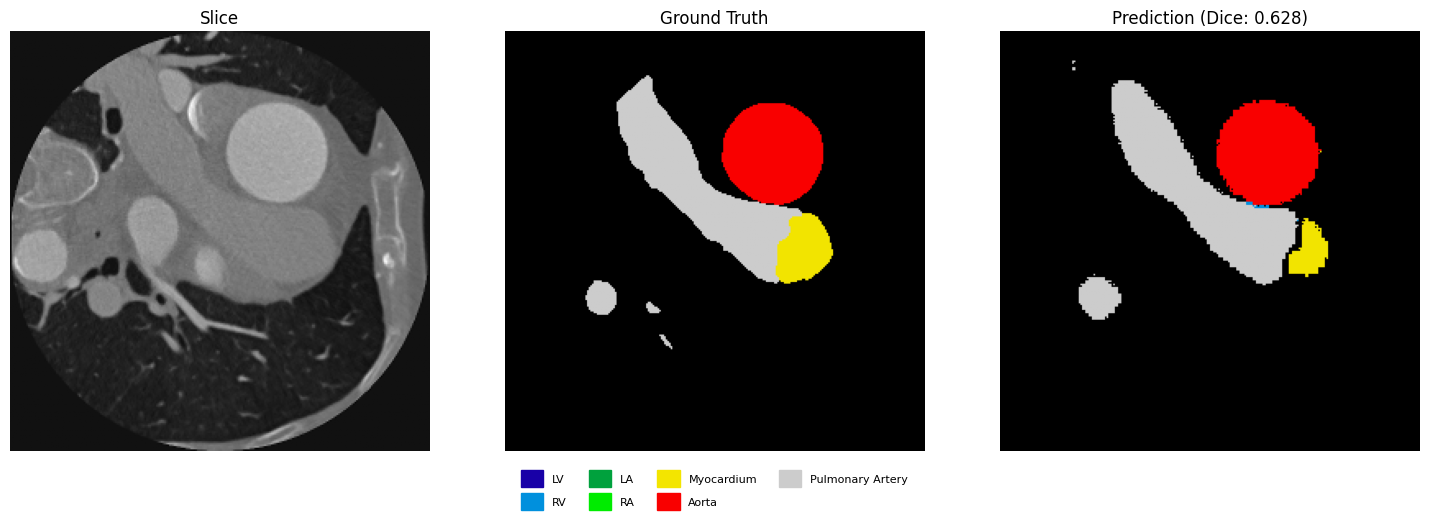

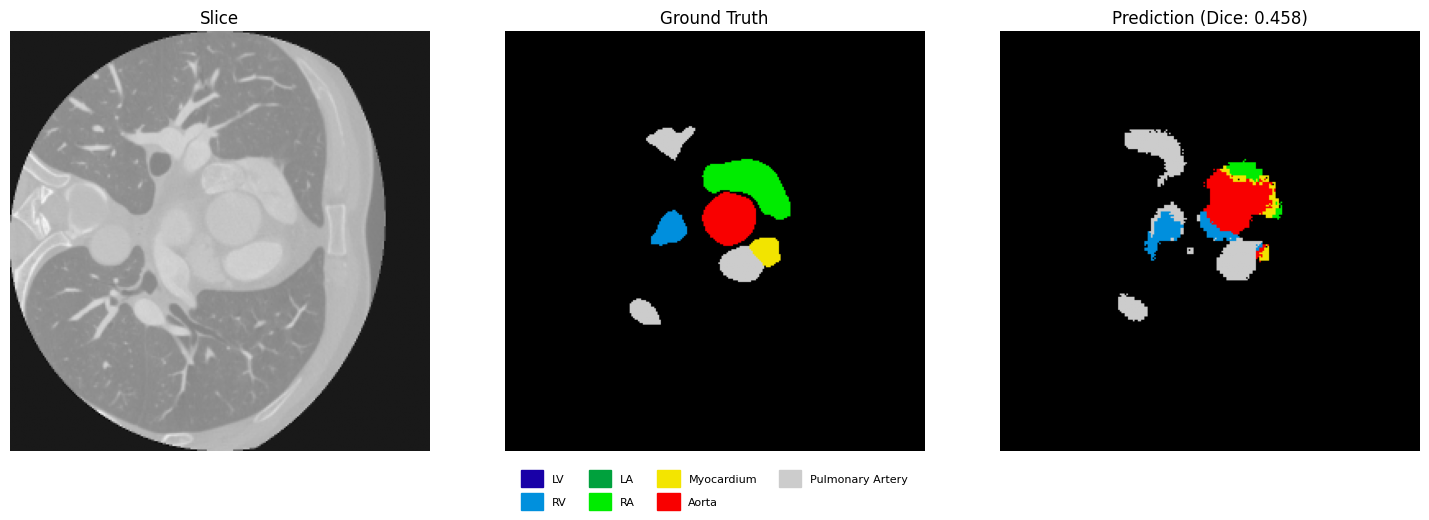

In [20]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import matplotlib.patches as mpatches

test_dir = '/content/npz_dataset/pack/processed_data/ct_256/test/npz'
weights_path = 'ct_teacher_epoch20.pth'
num_classes = 8
batch_size = 16
num_to_visualize = 20

label_names = [
    "Background", "LV", "RV", "LA", "RA", "Myocardium", "Aorta", "Pulmonary Artery"
]

model = ENet(nclass=8, in_channels=3)
model.load_state_dict(torch.load(weights_path, map_location='cuda:0'))
model = model.cuda()
model.eval()

test_dataset = StackedSliceDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def compute_dice_per_class(pred, target, num_classes):
    dices = []
    for cls in range(num_classes):
        pred_bin = (pred == cls).astype(np.uint8)
        target_bin = (target == cls).astype(np.uint8)
        intersection = np.sum(pred_bin * target_bin)
        union = np.sum(pred_bin) + np.sum(target_bin)
        dice = 2 * intersection / union if union > 0 else np.nan
        dices.append(dice)
    return dices

dice_scores_all = []
class_wise_dices = [[] for _ in range(num_classes)]
all_preds, all_gts = [], []

for images, masks in tqdm(test_loader, desc="Test Inference"):
    images = images.cuda()
    masks = masks.cuda()

    with torch.no_grad():
        logits, _, _ = model(images)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

    for pred, gt in zip(preds.cpu().numpy(), masks.cpu().numpy()):
        dices = compute_dice_per_class(pred, gt, num_classes)
        for cls in range(num_classes):
            if not np.isnan(dices[cls]):
                class_wise_dices[cls].append(dices[cls])
        dice_scores_all.append(np.nanmean(dices[1:]))
        all_preds.append(pred)
        all_gts.append(gt)

print("\nPer-Class Dice Scores (Test Set):")
for i in range(1, num_classes):
    if len(class_wise_dices[i]):
        avg = np.mean(class_wise_dices[i])
        print(f"  {label_names[i]:<20}: Dice = {avg:.4f}")
    else:
        print(f"  {label_names[i]:<20}: Dice = N/A")

print(f"\nAverage Dice Score on Test Set: {np.nanmean(dice_scores_all):.4f}")

label_map = {
    1: "LV", 2: "RV", 3: "LA", 4: "RA", 5: "Myocardium", 6: "Aorta", 7: "Pulmonary Artery"
}

sample_indices = random.sample(range(len(all_preds)), num_to_visualize)

for idx in sample_indices:
    input_tensor, _ = test_dataset[idx]
    input_center = input_tensor[1].numpy()  # Middle slice

    pred = all_preds[idx]
    gt = all_gts[idx]
    dice = np.nanmean(compute_dice_per_class(pred, gt, num_classes)[1:])

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(input_center, cmap='gray')
    axs[0].set_title("Slice")
    axs[0].axis('off')

    axs[1].imshow(gt, cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred, cmap='nipy_spectral')
    axs[2].set_title(f"Prediction (Dice: {dice:.3f})")
    axs[2].axis('off')

    cmap = plt.get_cmap("nipy_spectral")
    handles = [
        mpatches.Patch(color=cmap(cls / len(label_map)), label=name)
        for cls, name in label_map.items()
    ]
    fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=8, handleheight=2, handlelength=2)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()